## BraTS2020 dataset
https://www.kaggle.com/datasets/awsaf49/brats2020-training-data

脳腫瘍のデータセット
Brain Tumor Segmentation(BraTS2020)

Annotations comprise
- the necrotic and non-enhancing tumor core (NCR/NET — label 1)
- the peritumoral edema (ED — label 2)
- the GD-enhancing tumor (ET — label 4)

マスクの値は次の４種類： (日本語訳は DeepL による)
```
(0, 0, 0) ・・・ Background
(0, 0, 1) ・・・ necrotic and non-enhancing tumor core (NCR/NET — label 1) (壊死した非強化腫瘍コア)
(0, 1, 0) ・・・ peritumoral edema (ED — label 2) (腫瘍周囲浮腫)
(1, 0, 0) ・・・ GD-enhancing tumor (ET — label 4) (GD増強腫瘍)
```


---
## PyTorchとU-Netで作る領域分割モデル
下記サイトからのコピペ ＆ Brain Tumor Segmentation へマッチするよう，少々の改変

https://github.com/shnakazawa/computer-vision-baselines/blob/main/3_Semantic_Sgmentation_PyTorch_U-Net.ipynb

上記コードの解説：
https://zenn.dev/aidemy/articles/a43ebe82dfbb8b



## モジュールのインポート (Import Modules)

In [1]:
import os
import numpy as np
import pandas as pd
import math
import time
import random
import gc
from pathlib import Path
import h5py
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

print(f'PyTorch version {torch.__version__}')
print(f'Albumentations version {A.__version__}')

PyTorch version 2.0.1
Albumentations version 1.3.1


## ヘルパー関数の定義 (Define Helper Functions)

In [2]:
# helper functions

def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")  

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set seed
SEED = 42
seed_everything(SEED)

########################## ここから下が Brain Tumor dataset 特有の関数群 ##########################
'''
h5 ファイルから取り出した mask の RGB 値は次のようになっている。実際には RGB 値でなく，それぞれの部位を表すバイナリ表現である。
(0, 0, 0) ・・・ Background
(0, 0, 1) ・・・ necrotic and non-enhancing tumor core (NCR/NET — label 1) (壊死した非強化腫瘍コア)
(0, 1, 0) ・・・ peritumoral edema (ED — label 2) (腫瘍周囲浮腫)
(1, 0, 0) ・・・ GD-enhancing tumor (ET — label 4) (GD増強腫瘍)
'''

from enum import Enum
class BrainMRI_Modality(Enum):
    T1 = 1
    T1GD = 2
    T2 = 3
    T2FLAIR = 4

# BraTS2020 dataset から h5 ファイルを読み込み，image / mask に分割する。
# 同時にマスクについて，semantic label に置き換える
def _load_img(path):
    # f には image / mask の２種類が格納されている
    # かつマルチモーダルである。
    f = h5py.File(path)

    # 画像の処理
    # MRI 画像は，a) T1(ネイティブ), b) T1Gd(造影後T1強調), c) T2(T2強調), d) T2-FLAIR のマルチモーダルである。
    # また，データセット内のデータが平均 0, 標準偏差 1 に正規化されているため，
    # cv2.normalize()を使って最小 0, 最大1 に変換する。
    image = np.array(f['image']) # shape: (240, 240, 4)
    image_T1=cv2.normalize(image[:,:,0], None, norm_type=cv2.NORM_MINMAX) # T1
    image_T1Gd=cv2.normalize(image[:,:,1], None, norm_type=cv2.NORM_MINMAX) # T1Gd
    image_T2=cv2.normalize(image[:,:,2], None, norm_type=cv2.NORM_MINMAX) # T2
    image_T2FLAIR=cv2.normalize(image[:,:,3], None, norm_type=cv2.NORM_MINMAX) # T2-FLAIR

    # マスクの処理
    mask = np.array(f['mask']) # shape: (240, 240, 3)
    mask_core = cv2.normalize(mask[:, :, 0], None, norm_type=cv2.NORM_MINMAX)
    mask_mask2 = cv2.normalize(mask[:, :, 1], None, norm_type=cv2.NORM_MINMAX)
    mask_mask3 = cv2.normalize(mask[:, :, 2], None, norm_type=cv2.NORM_MINMAX)
    
    # semantic mask の作成 ・・・ (2023.11.10 メモ) あまり自信がないが，一応，これで background を含めて 4 class に分かれる
    mask = mask_core*3 + mask_mask2*1 + mask_mask3*2
    
    f.close()
    
    return image_T1, image_T1Gd, image_T2, image_T2FLAIR, mask

# 引数 brainMRI_modality : MRI画像のモダリティ
def load_img(path, brainMRI_modality=BrainMRI_Modality.T1):
    # 全てのモダリティの MRI 画像およびマスクを読み込む
    mage_T1, image_T1Gd, image_T2, image_T2FLAIR, mask = _load_img(path)
    
    # 引数 brainMRI_modality に応じて，要求された画像とマスクを返す
    if brainMRI_modality == BrainMRI_Modality.T1:
        return image_T1, mask
    elif brainMRI_modality == BrainMRI_Modality.T1GD:
        return image_T1Gd, mask
    elif brainMRI_modality == BrainMRI_Modality.T2:
        return image_T2, mask
    elif brainMRI_modality == BrainMRI_Modality.T2FLAIR:
        return image_T2FLAIR, mask


## データセット内のデータを眺めてみる

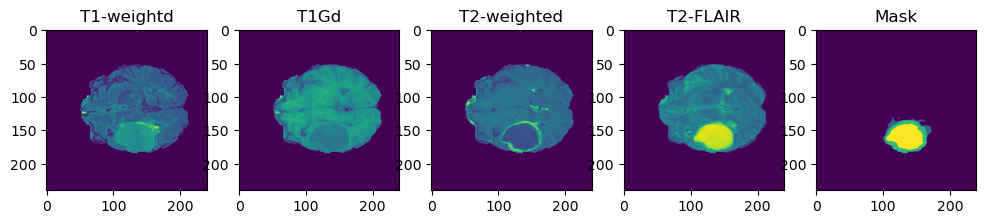

In [3]:
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2

# 適当な h5 ファイルを選択
filename = 'BraTS2020/BraTS2020_training_data/content/data/volume_194_slice_70.h5'
image_T1, image_T1Gd, image_T2, image_T2FLAIR, mask = _load_img(filename)

# MRI 画像およびマスクの描画
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 5, 1)
plt.imshow(image_T1)
plt.title("T1-weightd")

fig.add_subplot(1, 5, 2)
plt.imshow(image_T1Gd)
plt.title("T1Gd")

fig.add_subplot(1, 5, 3)
plt.imshow(image_T2)
plt.title("T2-weighted")

fig.add_subplot(1, 5, 4)
plt.imshow(image_T2FLAIR)
plt.title("T2-FLAIR")

fig.add_subplot(1, 5, 5)
plt.imshow(mask)
plt.title("Mask")

plt.show()

## パラメータ設定 (Set Config)

In [20]:
RUN_EDA = True
### RUN_TRAINING = True
### TRAIN_ALL = True # False # If true, train with all data and output a single model. If False, run cross-validation and output multiple models.
### FOLD_NUM = 5 # For cross-validation
EPOCHS = 20 # Training cycle
RUN_INFERENCE = True

# Directory setting
DATA_DIR = 'BraTS2020/'
MODEL_DIR = 'models/BraTS2020/'
CSV_SAVE_DIR = 'outputs/sartorius-cell-instance-segmentation/csv/'
IMG_SAVE_DIR = 'outputs/sartorius-cell-instance-segmentation/img/'

# BraTS2020 関連：入力画像として用いるモダリティを指定
BRAIN_MRI_MODALITY = BrainMRI_Modality.T1
# BRAIN_MRI_MODALITY = BrainMRI_Modality.T1GD
# BRAIN_MRI_MODALITY = BrainMRI_Modality.T2
# BRAIN_MRI_MODALITY = BrainMRI_Modality.T2FLAIR

# PyTorch variables
LOCAL_DEVICE = 'cuda' # 'cuda' or cpu'
NUM_WORKERS = 2
BATCH_SIZE = 8
WEIGHT_DECAY = 0.0001
LR = 0.0001
MOMENTUM = 0.9

# Set device
device = LOCAL_DEVICE
print(f'Using {device} device')

Using cuda device


## Load and Reshape a Table

In [21]:
# データセットを Pandas dataframe へ押し込む
def f_str(x):
    return '/'.join(x.split('/')[3:])

def id_str(x):
    return x.split('/')[-1].split('.')[0]

# df = pd.read_csv(DATA_DIR + 'train.csv')
# (メモ) slice_path を現状にマッチするよう修正
df = pd.read_csv(DATA_DIR + 'BraTS20 Training Metadata.csv')
df['slice_path'] = df['slice_path'].map(f_str)

df

,slice_path,target,volume,slice,label0_pxl_cnt,label1_pxl_cnt,label2_pxl_cnt,background_ratio
0,BraTS2020_training_data/content/data/volume_41...,0,41,0,0,0,0,1.0
1,BraTS2020_training_data/content/data/volume_41...,0,41,1,0,0,0,1.0
2,BraTS2020_training_data/content/data/volume_41...,0,41,2,0,0,0,1.0
3,BraTS2020_training_data/content/data/volume_41...,0,41,3,0,0,0,1.0
4,BraTS2020_training_data/content/data/volume_41...,0,41,4,0,0,0,1.0
...,...,...,...,...,...,...,...,...
57190,BraTS2020_training_data/content/data/volume_24...,0,241,150,0,0,0,1.0
57191,BraTS2020_training_data/content/data/volume_24...,0,241,151,0,0,0,1.0
57192,BraTS2020_training_data/content/data/volume_24...,0,241,152,0,0,0,1.0
57193,BraTS2020_training_data/content/data/volume_24...,0,241,153,0,0,0,1.0


ratio of slice which background_ratio is equal to 1.0: 0.5730046332721391


<Axes: >

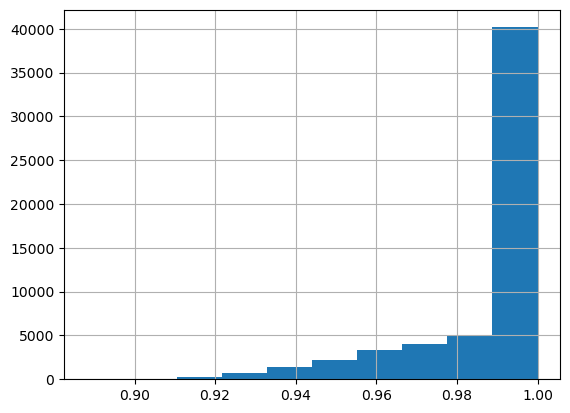

In [22]:
# background 率のヒストグラム
print("ratio of slice which background_ratio is equal to 1.0:", len(df[df['background_ratio']==1.0]) / len(df))
df['background_ratio'].hist()

In [23]:
# DataFrame の整形

# Background ratio が 1.0 のデータを削除 ・・・必要に応じて有効化する
### df = df[df["background_ratio"] != 1.0].reset_index()

# パス名の最後を id とする
df['id'] = df['slice_path'].map(id_str)

# データセットが大きすぎるため，全体の 10% をランダム抽出 ・・・コードの動作チェックのため少数とする
df = df.sample(frac=0.10).reset_index()

df

,index,slice_path,target,volume,slice,label0_pxl_cnt,label1_pxl_cnt,label2_pxl_cnt,background_ratio,id
0,44223,BraTS2020_training_data/content/data/volume_25...,1,255,48,182,347,1743,0.960556,volume_255_slice_48
1,23936,BraTS2020_training_data/content/data/volume_99...,1,99,66,0,33,0,0.999427,volume_99_slice_66
2,55904,BraTS2020_training_data/content/data/volume_33...,1,335,104,288,315,0,0.989531,volume_335_slice_104
3,33549,BraTS2020_training_data/content/data/volume_17...,0,176,69,0,0,0,1.000000,volume_176_slice_69
4,1219,BraTS2020_training_data/content/data/volume_31...,0,310,134,0,0,0,1.000000,volume_310_slice_134
...,...,...,...,...,...,...,...,...,...,...
5715,39948,BraTS2020_training_data/content/data/volume_71...,1,71,113,271,1457,528,0.960833,volume_71_slice_113
5716,37927,BraTS2020_training_data/content/data/volume_28...,0,282,107,0,0,0,1.000000,volume_282_slice_107
5717,3885,BraTS2020_training_data/content/data/volume_35...,0,358,10,0,0,0,1.000000,volume_358_slice_10
5718,41802,BraTS2020_training_data/content/data/volume_30...,1,303,107,636,387,34,0.981649,volume_303_slice_107


## 探索的データ分析 (Exploratory Data Analysis (EDA))

### 代表的な画像のチェック (Inspect Representative Images)

BraTS2020_training_data/content/data/volume_112_slice_75.h5
BraTS2020_training_data/content/data/volume_215_slice_126.h5
BraTS2020_training_data/content/data/volume_317_slice_139.h5
BraTS2020_training_data/content/data/volume_232_slice_85.h5
BraTS2020_training_data/content/data/volume_305_slice_7.h5
BraTS2020_training_data/content/data/volume_293_slice_111.h5


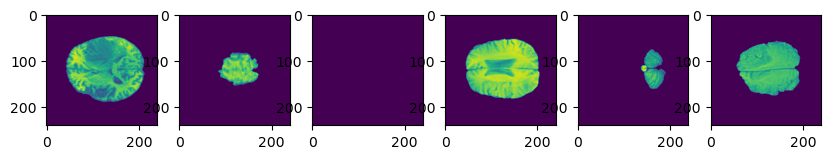

In [8]:
if RUN_EDA:
    img_names = df['slice_path'].values
    img_name_list = []
    img_list = []
    for i, img_name in enumerate(img_names):
        img_name_list.append(img_name) # この後の "Plot Mask" に対応するため，パス名を保存する
        image, mask = load_img(DATA_DIR + img_name, BRAIN_MRI_MODALITY) # MRI画像のモダリティを指定
        img_list.append(image)
        print(img_name)
        if i == 5: 
            break

    # print(np.array(img_list).shape) # (6, 240, 240)
    
    fig = plt.figure(figsize=(10, 3))
    for idx, img in enumerate(img_list):
        fig.add_subplot(1, len(img_list), idx+1)
        plt.imshow(img)
    plt.show()
else:
    print('RUN_EDA is False')

### マスク画像のプロット (Plot Mask)

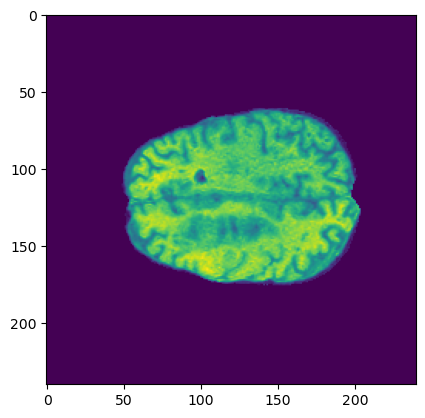

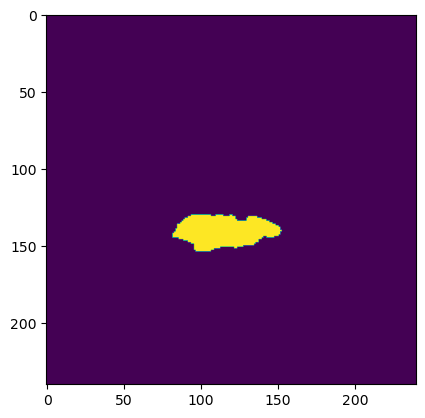

In [9]:
if RUN_EDA:
    # image_id = grouped_df['id'][0]
    image_id = df['id'][256]
    slice_path = df[df['id']==image_id]['slice_path'].values[0]

    # img = load_img(f'{DATA_DIR}train/{image_id}.png')
    img, masked_img = load_img(f'{DATA_DIR}{slice_path}', BRAIN_MRI_MODALITY) # MRI画像のモダリティを指定
    #masks = df[df['id'] == image_id]['annotation'].tolist()
    #masked_img = create_mask_image(img, masks)
    plt.figure()
    plt.imshow(img)
    plt.figure()
    plt.imshow(masked_img)
else:
    print('RUN_EDA is False')

### 画像サイズのチェック (Check Image Shape)

In [10]:
# データが大きいため，これの実行には相当に時間を要する
if RUN_EDA:
    img_shape = set()
    img_ext = set()
    # img_names = Path(DATA_DIR+'train/').glob('*')
    # img_names = Path(DATA_DIR + 'BraTS2020_training_data/content/data/').glob('*.h5')
    # pbar = tqdm(img_names, total=len(grouped_df))
    pbar = tqdm(df['slice_path'].tolist())
    for img_name in pbar:
        ### print(DATA_DIR + img_name)
        try:
            img, mask = load_img(DATA_DIR + img_name) # MRI画像のモダリティ: デフォルト値
        except:
            print(img_name)
            import sys
            sys.exit()
        img_shape.add(img.shape)
        img_ext.add(img_name.split('/')[-1].split('.')[-1])
    print(f'Image shapes are {img_shape}.')
    print(f'Image extensions are {img_ext}.')

  0%|          | 0/5720 [00:00<?, ?it/s]

BraTS2020_training_data/content/data/volume_228_slice_87.h5


AttributeError: 'tuple' object has no attribute 'tb_frame'

### 画素値のヒストグラム (Plot histogram of pixel values)

In [22]:
# データが大きいため，これの実行には相当に時間を要する
# (2023.11.10 メモ) MRI 画像は grayscale 画像だから，color histogram を求める意味がない
if RUN_EDA:
    # img_names = Path(DATA_DIR+'train/').glob('*')
    img_names = Path(DATA_DIR + 'BraTS2020_training_data/content/data/').glob('*.h5')
    plt.figure(figsize=(10,10))
    pbar = tqdm(df['slice_path'].tolist())
    for img_name in pbar:
        img, mask = load_img(DATA_DIR + img_name) # MRI画像のモダリティ: デフォルト値
        # img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
        hist = cv2.calcHist([img],[0],None,[256],[0,256])
        plt.plot(hist)
    plt.show()
else:
    print('RUN_EDA is False')

  0%|          | 0/1221 [00:00<?, ?it/s]

error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/histogram.cpp:1008: error: (-210:Unsupported format or combination of formats)  in function 'calcHist'


<Figure size 1000x1000 with 0 Axes>

## モデル要素の定義 (Define Model Components)

### 画像変換およびデータ拡張の定義 (Define Image Transformation and Augmentation)

In [24]:
# Image Transformation & Augmentation
def transform_train():
    transforms = [
        # Brain Tumor dataset は 240 x 240 のサイズだから Resize しない
        # A.Resize(256,256,p=1),
        #### A.Crop(x_min=50, y_min=50, x_max=200, y_max=200, p=1),
        A.HorizontalFlip(p=0.5),
        A.Transpose(p=0.5),
        ToTensorV2(p=1)
    ]
    return A.Compose(transforms)


# Validation images undergo only resizing.
def transform_valid():
    transforms = [
        # Brain Tumor dataset は 240 x 240 のサイズだから Resize しない
        # A.Resize(256,256,p=1),
        ### A.Crop(x_min=50, y_min=50, x_max=200, y_max=200, p=1),
        ToTensorV2(p=1)
    ]
    return A.Compose(transforms)

### データセットの定義 (Define Datasets)

In [25]:
# Dataset
class BrainTumorDataset(Dataset):
    def __init__(self, image_ids, dataframe, data_root, transforms=None, stage='train'):
        super().__init__()
        self.image_ids = image_ids
        self.dataframe = dataframe
        self.data_root = data_root
        self.transforms = transforms
        self.stage = stage

    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        # Load images
        slice_path = self.dataframe[self.dataframe['id']==image_id]['slice_path'].values[0]
        # image  = load_img(f'{self.data_root}{image_id}.png').astype(np.float32)
        image, mask_image = load_img(f'{self.data_root}{slice_path}', BRAIN_MRI_MODALITY) # MRI画像のモダリティを指定
        image = image.astype(np.float32)
        mask_image = mask_image.astype(np.float32)

        # For training and validation
        if self.stage == 'train':
            # masks
            ### masks = self.dataframe[self.dataframe['id'] == image_id]['annotation'].tolist()
            ### mask_image = create_mask_image(image, masks)

            # Transform images and masks
            if self.transforms:
                transformed = self.transforms(image=image, mask=mask_image)
                image, mask_image = transformed['image'], transformed['mask']
            return image, mask_image, image_id
        
        # For test
        else:
            # Transform images
            if self.transforms:
                image =self.transforms(image=image)['image']
            
            return image, image_id

### データローダの定義 (Define the DataLoader)

In [26]:
# DataLoader

# def create_dataloader(grouped_df, df, trn_idx, val_idx):
def create_dataloader(df, trn_idx, val_idx):
    '''
    tmp_paths = glob.glob(DATA_DIR + "*.h5")
    paths = []
    for tmp_path in tmp_paths:
        paths.append(tmp_path.split('/')[-1])
    '''
        
    #train_ = grouped_df.loc[trn_idx,:].reset_index(drop=True)
    #valid_ = grouped_df.loc[val_idx,:].reset_index(drop=True)
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)

    # Dataset
    #train_datasets = CellDataset(train_['id'].to_numpy(), df, DATA_DIR+'BraTS2020_training_data/content/data/', transforms=transform_train())
    #valid_datasets = CellDataset(valid_['id'].to_numpy(), df, DATA_DIR+'BraTS2020_training_data/content/data/', transforms=transform_valid())
    train_datasets = BrainTumorDataset(train_['id'].to_numpy(), df, DATA_DIR, transforms=transform_train())
    valid_datasets = BrainTumorDataset(valid_['id'].to_numpy(), df, DATA_DIR, transforms=transform_valid())

    # Data Loader
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')
    valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    return train_loader, valid_loader

### モデルの定義 (Define the model)

In [27]:
class DoubleConv(nn.Module):
    """DoubleConv is a basic building block of the encoder and decoder components. 
    Consists of two convolutional layers followed by a ReLU activation function.
    """    
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.double_conv(x)
        return x


class Down(nn.Module):
    """Downscaling.
    Consists of two consecutive DoubleConv blocks followed by a max pooling operation.
    """    
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x


class Up(nn.Module):
    """Upscaling.
    Performed using transposed convolution and concatenation of feature maps from the corresponding "Down" operation.
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input tensor shape: (batch_size, channels, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
    

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        
        self.down4 = Down(512,1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = torch.sigmoid(x)
        return x

## 学習 (Run Training)

In [28]:
from sklearn.model_selection import train_test_split

# 学習データ／テストデータへの分割（id 列の値を分割)
trn_idx, val_idx = train_test_split(df['id'].to_numpy(), test_size=0.3, random_state=SEED, shuffle=True)

####folds = [folds] # 後の for 文で回せるようにした。(folds[np.newaxis, :, :]) でもいけるかも)        

# For Visualization
train_loss_list = []
valid_loss_list = []

# Load Data   
# train_datasets = CellDataset(grouped_df['id'].to_numpy(), df, DATA_DIR+'train/', transforms=transform_train())
#### いじったやつ ###train_datasets = CellDataset(df['id'].to_numpy(), df, DATA_DIR, transforms=transform_train())
train_datasets = BrainTumorDataset(trn_idx, df, DATA_DIR, transforms=transform_train())
train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')

train_losses = []

# モデルのインスタンス化
# Brain Tumor Segmentation では３つのクラスをもつ。
# background を加えて４クラスへのセグメンテーション問題である。
model = UNet(n_classes=4).to(device)

# オプティマイザの定義
# (2023.11.06) 多クラスの場合，「ピクセル単位の精度と多クラスのIoU」をチェックするのが妥当？
# https://qiita.com/nigo1973/items/c62578fccc7230ba48f8
# 多クラスの場合，nn.CrossEntropyLoss() を利用するのが一般的である。
# criterion = nn.BCELoss().to(device) # (2023.11.06 メモ) 2クラスの場合に BCELoss (Binary Cross Entropy) が用いられる
criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.SGD(model.parameters(), weight_decay=WEIGHT_DECAY, lr = LR, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LR)

# Start training
for epoch in range(EPOCHS):
    time_start = time.time()
    print(f'==========Epoch {epoch+1} Start Training==========')
    model.train()
    train_loss = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, masks, image_ids) in pbar:
        imgs = imgs.to(device).float()
        masks = masks.to(device).float()

        optimizer.zero_grad()

        output = model(imgs)
        loss = criterion(output, masks.long()) # (メモ) CrossEntroyLoss へ渡す場合，target(=masks)は Long であるべき
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    train_loss_list.append(train_loss)

    # print results from this epoch
    exec_t = int((time.time() - time_start)/60)
    print(f'Epoch : {epoch+1} - loss : {train_loss:.4f} / Exec time {exec_t} min\n')

print(f'Save model trained with all data')
os.makedirs(MODEL_DIR, exist_ok=True)
torch.save(model.state_dict(), MODEL_DIR+'segmentation.pth')
del model, optimizer, train_loader

gc.collect()
torch.cuda.empty_cache()

==========Epoch 1 Start Training==========


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.0863 / Exec time 2 min

==========Epoch 2 Start Training==========


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.8910 / Exec time 2 min

==========Epoch 3 Start Training==========


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.8143 / Exec time 2 min

Save model trained with all data


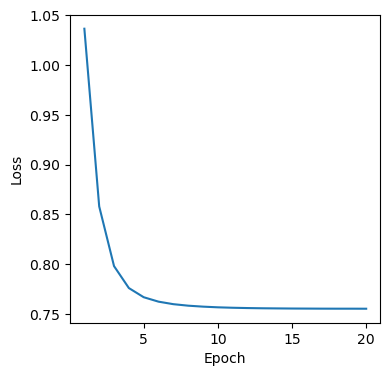

In [18]:
# train loss の推移を可視化
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(len(train_loss_list)) + 1

fig = plt.figure(figsize=(4,4))
plt.plot(epochs, train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## テストデータの推論 (Run Inference of Test Data)

In [29]:
if RUN_INFERENCE:
    ### train_ids, valid_ids = folds[0]
    train_ids, valid_ids = trn_idx, val_idx
    
    #files = os.listdir(DATA_DIR+'BraTS2020_training_data/content/data/')
    #image_ids = np.array([os.path.splitext(file)[0] for file in files])
    # ids = []
    # rle_test_preds = [] # (メモ) Brain Tumor の場合，マスクは画像で与えられるため，RLE という名称は変更する方がよい。
    test_preds = dict() # 2023.11.06 追加
    # original_size = (240, 240) # (width, height)
    original_size = (240, 240) # (width, height)

    # Load Data
    # test_datasets = CellDataset(image_ids, df, DATA_DIR+'test/', transforms=transform_valid(), stage='test')
    test_datasets = BrainTumorDataset(valid_ids, df, DATA_DIR, transforms=transform_valid(), stage='test')

    # Data Loader
    test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    # モデルおよびパラメータの読み込み
    model = UNet(n_classes=4).to(device)
    model.load_state_dict(torch.load(MODEL_DIR+'segmentation.pth'))
    
    INFERENCE_DIR = 'inference/BraTS2020/'
    os.makedirs(INFERENCE_DIR, exist_ok=True)
    
    # Start Inference
    print(f'==========Start Inference==========')
    with torch.no_grad():
        # test_preds = []
        for (imgs, image_ids) in tqdm(test_loader):
            imgs = imgs.to(device).float()
            output = model(imgs)

            # Convert the output from PyTorch to np.array
            output = output.detach().cpu().numpy()
            # print(output.shape) # (8, 3, 240, 240) # 8 はバッチサイズ
            
            # run length encoding
            for image_id, predicted_mask in zip(image_ids, output):
                # print(predicted_mask.shape) # (4,240, 240)
                predicted_mask = predicted_mask.transpose(1,2,0)
                # print(predicted_mask.shape) # (240, 240, 4)
                # predicted_mask = np.squeeze(predicted_mask) # 多クラスだから，squeeze は不要

                # 最大値をとるクラスを選択
                predicted_mask = predicted_mask.argmax(axis=2)
                # print(predicted_mask.shape) # (240, 240)

                # 全てが zero か否かを判定
                if np.all(predicted_mask == 0):
                    continue
                else:
                    print(predicted_mask.max(), end=" ")
                    
                # resize
                # predicted_mask = cv2.resize(predicted_mask, original_size) # Resize していないから，改めての resize は不要
                
                #rle_mask = encode_rle(predicted_mask)
                #ids.append(image_id)
                #rle_test_preds.append(rle_mask)

                # test_preds[image_id] = predicted_mask
                # (2023.11.06) opencv の画像形式にマッチさせるため，transpose
                # predicted_mask = predicted_mask.transpose(1,2,0)
                # print(predicted_mask.shape) # (240, 240, 3)
                cv2.imwrite(INFERENCE_DIR + image_id + ".png", predicted_mask)
    '''
    # これは多分，コンペへ提出するための保存
    submission_df = pd.DataFrame({
        'id': ids, 'predicted': rle_test_preds
    })
    print(submission_df.head())
    '''

else:
    print('RUN_INFERENCE is False')

==========Start Inference==========


  0%|          | 0/215 [00:00<?, ?it/s]

2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

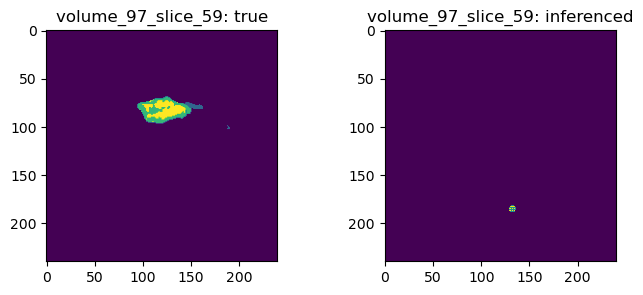

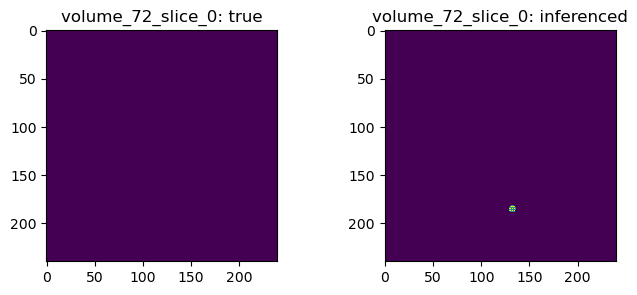

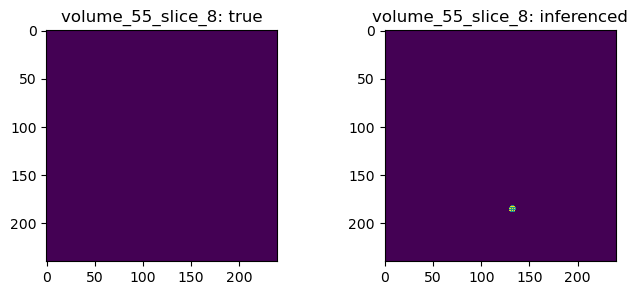

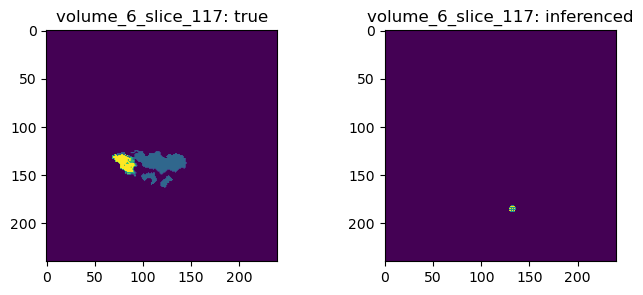

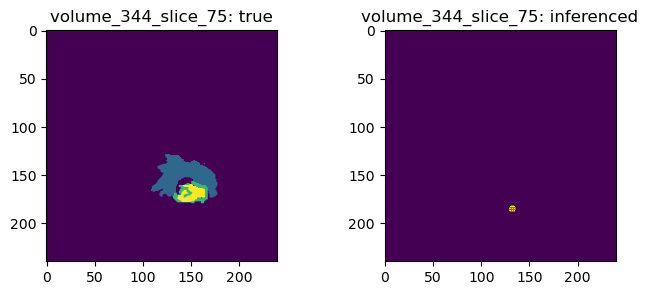

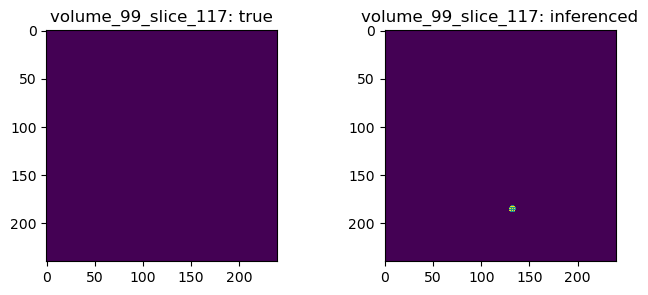

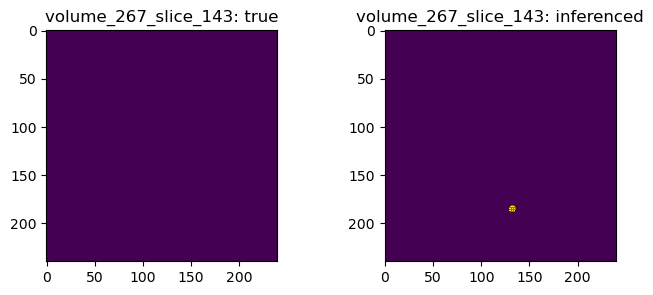

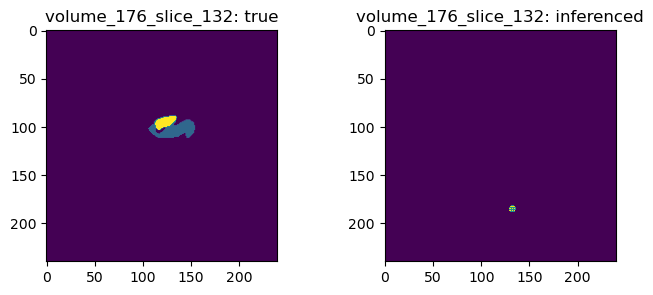

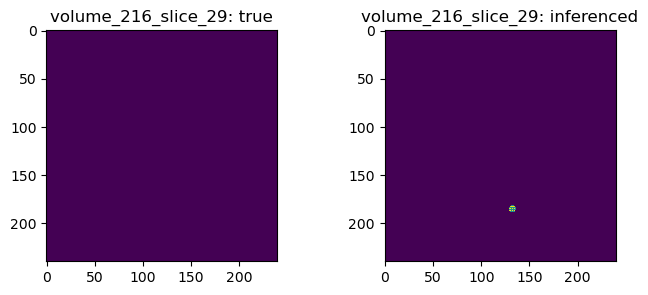

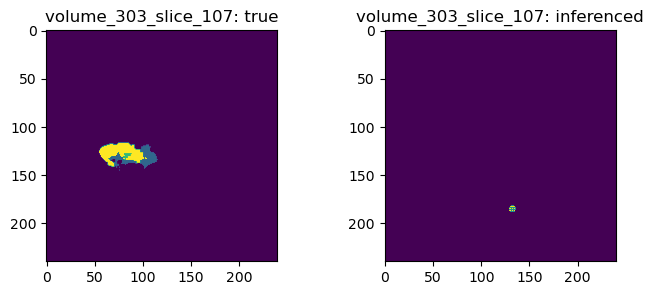

In [30]:
# ランダムに 10件の推論結果のパスを取り出す
import glob
import matplotlib.pyplot as plt
import cv2

INFERENCE_DIR = 'inference/BraTS2020/'
paths = glob.glob(INFERENCE_DIR + "*.png")

paths = paths[:10]

# 上記の各々について ground truth と inference のペアを取り出し，並べて表示する
target_idx = 0
for target_idx in range(10):
    filename = paths[target_idx].split('/')[-1].split('.')[0]
    original_h5 = 'BraTS2020/BraTS2020_training_data/content/data/' + filename + '.h5'

    # 正解 (ground truth)
    _, mask = load_img(original_h5, BRAIN_MRI_MODALITY)

    # inference
    inference_mask = cv2.imread(paths[target_idx], 0)
    
    # 表示
    fig = plt.figure(figsize=(8,3))
    fig.add_subplot(1, 2, 1)
    plt.imshow(mask)
    plt.title("{}: true".format(filename))

    fig.add_subplot(1, 2, 2)
    plt.imshow(inference_mask)
    plt.title("{}: inferenced".format(filename))

plt.show()

# これ以降は触っていない

In [ ]:
# (メモ) 動作チェックしていない
def show_validation_score(train_loss_list, valid_loss_list, save=False, save_dir=IMG_SAVE_DIR, save_name='segmentation_validation_score.png'):
    fig = plt.figure(figsize=(10,10))
    for i in range(FOLD_NUM):
        train_loss = train_loss_list[i]
        valid_loss = valid_loss_list[i]
        
        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM)), math.ceil(np.sqrt(FOLD_NUM)), i+1, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_loss, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_loss, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
    
    plt.tight_layout()
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir+save_name)
    else:
        plt.show()

In [17]:
# 一番，最後のデータを使って予測結果(マスク画像)を出力

# Threshold for mask prediction
THRESHOLD = 0.3

if RUN_INFERENCE:
    plt.imshow(predicted_mask > THRESHOLD)
else:
    print('RUN_INFERENCE is False')

RUN_INFERENCE is False


In [18]:
# (メモ) コンペ提出用だから，不要
'''
if RUN_INFERENCE:
    if KAGGLE:
        submission_df.to_csv('submission.csv', index=False)
    else:
        submission_df.to_csv(CSV_SAVE_DIR+f'segmentation_test.csv')

else:
    print('RUN_INFERENCE is False')
'''

RUN_INFERENCE is False


In [19]:
if RUN_INFERENCE:
    # target = submission_df.iloc[0]
    target = test_preds.keys()[0]
    # img = load_img(f'{DATA_DIR}test/{target["id"]}.png')
    #masks = [target['predicted']]
    #masked_img = create_mask_image(img, masks)
    img, _ = load_img(f'{DATA_DIR}BraTS2020_training_data/content/data/{target}.h5', BRAIN_MRI_MODALITY) # 2023.11.06 追加
    masked_img = test_preds[target] # 2023.11.06 追加
    
    plt.figure()
    plt.imshow(img)
    plt.figure()
    plt.imshow(masked_img)

else:
    print('RUN_INFERENCE is False')

RUN_INFERENCE is False
